<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>Tutorial 11: Decision Trees for Classification</h2></center>
<br>


In this tutorial we can consider a case study from the customer relationship management area in the context of decision trees.

<a href="#Customer-Retention-Data">Customer Retention Data</a> <br>
<a href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#Decision-Tree">Decision Tree</a> <br>
<a href="#Logistic-Regression">Logistic Regression</a> <br>
<a href="#K-Nearest-Neighbours-Classifier">K-Nearest Neighbours Classifier</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

## Customer Retention Data

This dataset is taken from [Statistical Methods in Customer Relationship Management](http://onlinelibrary.wiley.com/book/10.1002/9781118349212), authored by  V. Kumar and J. Andrew Petersen.

**Business objective**: to predict which customers will end the relationship with the business, i.e., which customers will churn.

In [4]:
data = pd.read_excel('Datasets/CustomerChurn.xls', index_col=[0])
data['Churn'] = (data['Censor']==0).astype(int)
data.head()

,Duration,Censor,Avg_Ret_Exp,Avg_Ret_Exp_SQ,Industry,Revenue,Employees,Total_Crossbuy,Total_Freq,Total_Freq_SQ,Churn
Customer,,,,,,,,,,,
1,500,0,89.61,8029.9521,1,30.16,1240,6,16,256,1
2,730,1,49.89,2489.0121,0,39.80,166,6,10,100,0
3,730,1,40.70,1656.4900,0,54.93,1016,2,14,196,0
4,340,0,85.76,7354.7776,0,45.83,122,2,15,225,1
5,730,1,31.90,1017.6100,0,69.03,313,1,9,81,0


In [5]:
response='Churn'
predictors=['Avg_Ret_Exp', 'Revenue', 'Employees', 'Total_Crossbuy', 'Total_Freq', 'Industry']

data = data[[response]+predictors] # discarding variables that we will not use

We split the data into training (80%) and test (20%) sets before proceeding. 

In [6]:
from sklearn.model_selection import train_test_split

index_train, index_test  = train_test_split(np.array(data.index), stratify=data[response], train_size=0.8, random_state=5)

train = data.loc[index_train,].copy()
test =  data.loc[index_test,:].copy()

y_train = train[response]
y_test = test[response]

X_train = train[predictors]
X_test = test[predictors]

## Exploratory Data Analysis

We start by computing descriptive statistics on the response and predictors.

It can be observed that 46% of customers ended the relationship with the business:

In [7]:
train.describe().round(2)

,Churn,Avg_Ret_Exp,Revenue,Employees,Total_Crossbuy,Total_Freq,Industry
count,400.00,400.00,400.00,400.00,400.00,400.00,400.00
mean,0.46,36.10,39.74,671.75,3.40,11.47,0.60
std,0.50,33.01,16.33,468.54,1.54,5.85,0.49
min,0.00,0.04,2.35,4.00,1.00,1.00,0.00
25%,0.00,10.08,27.86,286.25,2.00,6.00,0.00
50%,0.00,24.74,39.94,588.50,3.00,12.00,1.00
75%,1.00,57.24,51.69,1025.50,5.00,17.00,1.00
max,1.00,145.16,74.97,1950.00,6.00,21.00,1.00


We use histograms to further explore the univariate distribution of the numerical predictors:

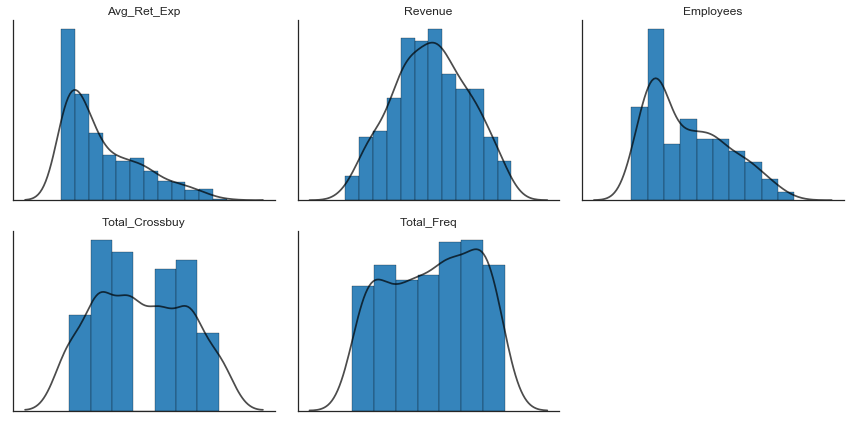

In [9]:
from statlearning import plot_histograms

plot_histograms(train[predictors[:-1]]) # excludes the last variable, since it is binary
plt.show()

To explore the relationship between the predictors and the response, we use univariate logistic regression plots:

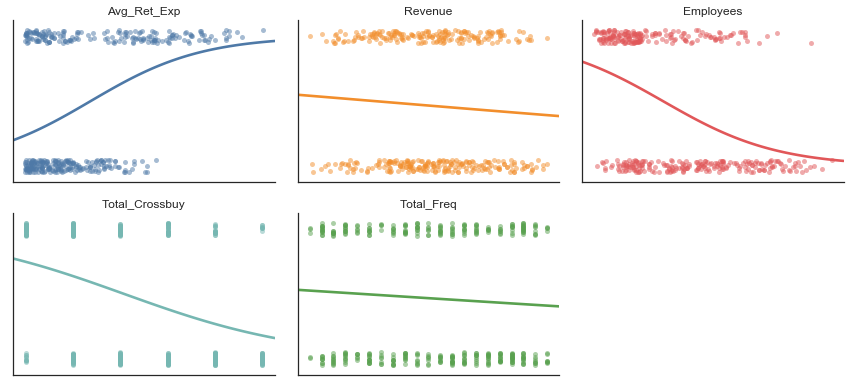

In [10]:
from statlearning import plot_logistic_regressions

with sns.color_palette(crayon):
    plot_logistic_regressions(train[predictors[:-1]], train[response])
    plt.show()

The class-conditional distributions (densities) accross the predictors are shown below:

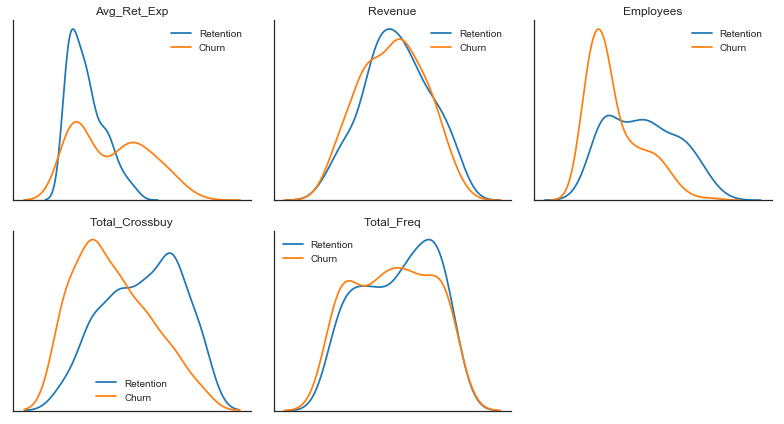

In [11]:
from statlearning import plot_conditional_distributions

plot_conditional_distributions(train[predictors[:-1]], y_train, labels=['Retention', 'Churn'])
plt.show()

A higher proportion of B2B prospects (50.6%) churned compared to the non-B2B prospects (40.3%):

In [12]:
table=pd.crosstab(train[response], train['Industry'])
table = (table/table.sum()).round(3)
table

Industry,0,1
Churn,,
0,0.597,0.494
1,0.403,0.506


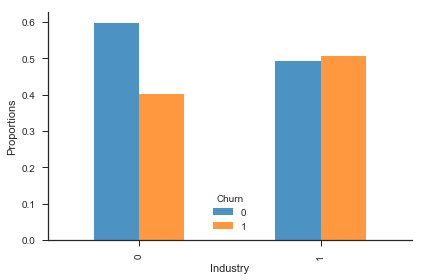

In [13]:
fig, ax = plt.subplots(figsize=(6,4))
(table.T).plot(kind='bar', alpha=0.8, ax=ax)
ax.set_xlabel('Industry')
ax.set_ylabel('Proportions')
ax.legend_.set_title('Churn')
plt.tight_layout()
sns.despine()
plt.show()

## Decision Tree

The basic syntax for fitting a classification tree by recursive binary splitting is provided below.  Here we allow the tree to have a maximum depth of 2 in order to facilitate visualisation. We also specify that the minimum number of "samples" (i.e. clients) in the terminal nodes is 5. We do this to highlight the importance of explicitly controlling this tuning parameter.

In [14]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=5)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

We have two options for displaying Decision Tree diagrams.  

**Option 1 (the simpler one)**: display the diagrams externally using <TT>WebGraphviz</TT>.

- Open http://www.webgraphviz.com/ in a new browser window

- Run the code in the cell below (in your Jupyter notebook), copy the output and paste it into the WebGraphviz' Text Area. Click "Generate Graph!" to produce the tree diagram.


**Option 2**:  display the diagrams within the Jupyter notebook:

To display the diagram within your Jupyter notebook please use <TT>homebrew</TT>, which can be installed via the following links:

Mac Users: https://www.howtogeek.com/211541/homebrew-for-os-x-easily-installs-desktop-apps-and-terminal-utilities/) 

PC Users: https://docs.brew.sh/Homebrew-on-Linux

Once homebrew is installed, open up the terminal and type in <TT>brew install graphviz</TT>.  This installs the <TT>graphviz</TT> package, wchich we can use to produce decision tree diagrams.  The corresponding code is provided further below.


You should experiment with letting the tree grow more (by changing the value for max_depth) and interpreting the result.

The next cell can be used to display the tree diagram externally (**Option 1**):

In [15]:
# This cell can be used to display the tree diagram externally (Option 1)

from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None, feature_names=predictors, impurity=False,
                           class_names=['retention','churn'], rounded=True) 
print(dot_data) #copy and paste the output into the WebGraphviz' Text Area

digraph Tree {
node [shape=box, style="rounded", color="black", fontname=helvetica] ;
edge [fontname=helvetica] ;
0 [label="Avg_Ret_Exp <= 66.77\nsamples = 400\nvalue = [214, 186]\nclass = retention"] ;
1 [label="Employees <= 395.0\nsamples = 323\nvalue = [209, 114]\nclass = retention"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="samples = 132\nvalue = [51, 81]\nclass = churn"] ;
1 -> 2 ;
3 [label="samples = 191\nvalue = [158, 33]\nclass = retention"] ;
1 -> 3 ;
4 [label="Employees <= 1225.5\nsamples = 77\nvalue = [5, 72]\nclass = churn"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="samples = 64\nvalue = [0, 64]\nclass = churn"] ;
4 -> 5 ;
6 [label="samples = 13\nvalue = [5, 8]\nclass = churn"] ;
4 -> 6 ;
}


The next cell can be used to display the tree diagram within the Jupyter notebook if you have done all the installations (**Option 2**):

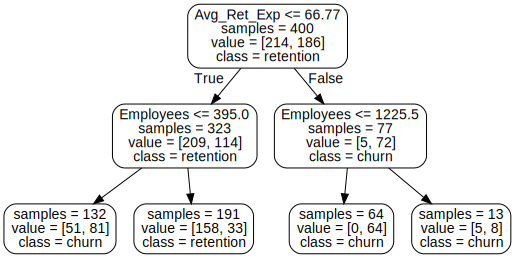

In [16]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None, feature_names=predictors, impurity=False,
                           class_names=['retention','churn'], rounded=True) 
graph = graphviz.Source(dot_data)
graph.render('tree01') # saves tree to a file
graph

Next, we should find a tree of optimal size for prediction. Unfortunately, <TT>scikit-learn</TT> does not support cost-complexity pruning. As an alternative, we select the depth and minimum node size using the automated [<TT>GridSearchCV</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) funtion for this purpose.

In [17]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model = DecisionTreeClassifier(criterion='entropy')

tuning_parameters = {
    'min_samples_leaf': [1,5,10,20,30,40,50],
}

tree_search = GridSearchCV(model, tuning_parameters, cv= 5 , return_train_score=False)
tree_search.fit(X_train, y_train)

tree = tree_search.best_estimator_

print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Best parameters found by grid search: {'min_samples_leaf': 40} 



The next cell can be used to display the tree diagram externally (**Option 1**):

In [18]:
dot_data = export_graphviz(tree, out_file=None, feature_names=predictors, impurity=False,
                           class_names=['retention','churn'], rounded=True) 
print(dot_data)

digraph Tree {
node [shape=box, style="rounded", color="black", fontname=helvetica] ;
edge [fontname=helvetica] ;
0 [label="Avg_Ret_Exp <= 66.77\nsamples = 400\nvalue = [214, 186]\nclass = retention"] ;
1 [label="Employees <= 395.0\nsamples = 323\nvalue = [209, 114]\nclass = retention"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Total_Crossbuy <= 3.5\nsamples = 132\nvalue = [51, 81]\nclass = churn"] ;
1 -> 2 ;
3 [label="samples = 70\nvalue = [11, 59]\nclass = churn"] ;
2 -> 3 ;
4 [label="samples = 62\nvalue = [40, 22]\nclass = retention"] ;
2 -> 4 ;
5 [label="Total_Crossbuy <= 2.5\nsamples = 191\nvalue = [158, 33]\nclass = retention"] ;
1 -> 5 ;
6 [label="samples = 64\nvalue = [40, 24]\nclass = retention"] ;
5 -> 6 ;
7 [label="Employees <= 752.5\nsamples = 127\nvalue = [118, 9]\nclass = retention"] ;
5 -> 7 ;
8 [label="samples = 48\nvalue = [41, 7]\nclass = retention"] ;
7 -> 8 ;
9 [label="samples = 79\nvalue = [77, 2]\nclass = retention"] ;
7 -> 9 ;
10 [

The next cell can be used to display the tree diagram within the Jupyter notebook  if you have done all the installations (**Option 2**):

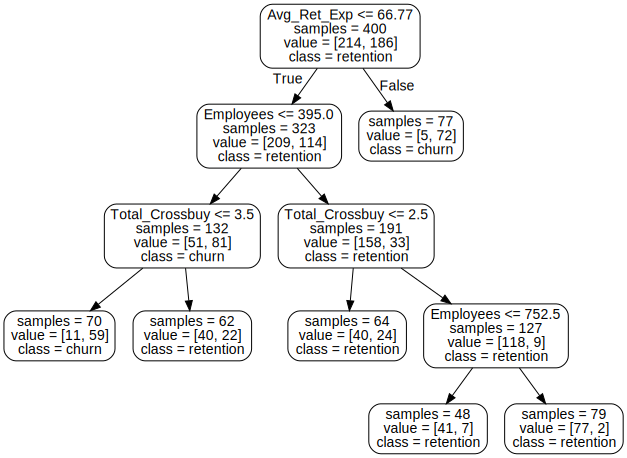

In [19]:
dot_data = export_graphviz(tree, out_file=None, feature_names=predictors, impurity=False,
                           class_names=['retention','churn'], rounded=True) 
graph = graphviz.Source(dot_data)
graph.render('tree02') # saves tree to a file
graph

## Bagging

We can use the following syntax to implement bagging for the classification trees (however, note that bagging is also a special case of random forests).

In [20]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(DecisionTreeClassifier(criterion='entropy'), n_estimators=1000, random_state=1)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=1000, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

## Random Forest

The syntax to implement a random forest classifier is as follows.

In [21]:
from sklearn.ensemble import  RandomForestClassifier
rf = RandomForestClassifier(criterion='entropy', max_features= 2, min_samples_leaf=5, n_estimators=1000, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

To tune the random forest, we should select a parameter that controls the size of the trees (such as the minimum number of observations in a terminal node) and the number of predictors that are sampled as candidate split variables at each node of a tree.

In [22]:
%%time

model = RandomForestClassifier(criterion = 'entropy',  n_estimators=1000)

tuning_parameters = {
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'max_features': np.arange(1, len(predictors)+1),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 16, return_train_score=False, n_jobs=4)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 1, 'max_features': 5} 

CPU times: user 1.48 s, sys: 50.8 ms, total: 1.53 s
Wall time: 24.5 s


After tuning the random forest, we may want to increase the number of trees (using the n_estimators parameter) to improve accuracy.

In [23]:
rf.n_estimators = 10000
rf.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

We use a funtion the statlearning module to plot the variable importances.

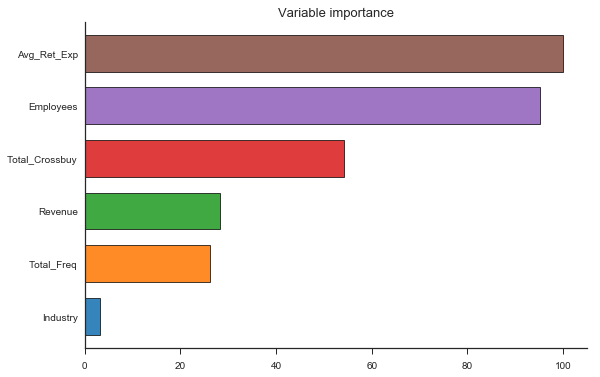

In [24]:
from statlearning import plot_feature_importance

plot_feature_importance(rf, predictors)
plt.show()

We now implement some "old" methods, logistic regression and KNN, for comparison.

## Logistic Regression

We estimate a [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with Scikit-Learn as follows:  

In [25]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(C=1e3)
logit.fit(X_train, y_train)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## K-Nearest Neighbours Classifier

For the KNN classifier, we need to write a function to select the number of neighbours by cross validation. We use the [<TT>KNeighborsClassifier</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) class to fit.

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

def knn_cv(X_train, y_train):
    
    neighbours = np.arange(1, 51)
    best_score = 0
    
    for k in neighbours:
        knn = KNeighborsClassifier(n_neighbors = k ,  metric='mahalanobis', metric_params={'V': X_train.cov()})
        score = np.mean(cross_val_score(knn, X_train, y_train, cv=10, scoring = 'accuracy'))
        if score >= best_score:
            best = knn
            best_score = score
    
    return best
        
knn = knn_cv(X_train, y_train) 
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='mahalanobis',
           metric_params={'V':                 Avg_Ret_Exp     Revenue      Employees  Total_Crossbuy  \
Avg_Ret_Exp     1089.794985  -26.005308     -92.126184       -2.695855
Revenue          -26.005308  266.668850      76.269418       -2.042006
Employees        -92.126184   76.269418  219526.835833    ...885363   0.002018
Total_Freq       34.249724   0.046942
Industry          0.046942   0.240094  },
           n_jobs=1, n_neighbors=35, p=2, weights='uniform')

## Model Evaluation

Decision tree outperforms the other methods when predicting negative cases (true negative rate) but peforms poorly when predicting positive cases (true positive rate).  Bagging and random forest result in the best ROC curves (highest AUC values).

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score

columns=['Error rate', 'True Positive Rate', 'True Negative Rate', 'AUC', 'Precision']
rows=['Logistic Regression', 'KNN', 'Decision Tree', 'Bagged Trees', 'Random Forest']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, knn, tree, bag, rf]

y_prob = np.zeros((len(test), len(rows)))

for i, method in enumerate(methods):
    
    y_pred = method.predict(X_test)
    y_prob[:, i] = method.predict_proba(X_test)[:,1]

    confusion  = confusion_matrix(y_test, y_pred) 

    results.iloc[i,0]=  1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,3]=  roc_auc_score(y_test, y_prob[:,i])
    results.iloc[i,4]=  precision_score(y_test, y_pred)

results.round(3)

,Error rate,True Positive Rate,True Negative Rate,AUC,Precision
Logistic Regression,0.24,0.783,0.741,0.841,0.720
KNN,0.29,0.652,0.759,0.822,0.698
Decision Tree,0.26,0.609,0.852,0.815,0.778
Bagged Trees,0.21,0.848,0.741,0.880,0.736
Random Forest,0.22,0.848,0.722,0.882,0.722


In the following ROC plot, the **True Positive Rate** (sensitivity) is displayed on the Y axis, while the **True Negative Rate** (specificity) is displayed on the X axis.

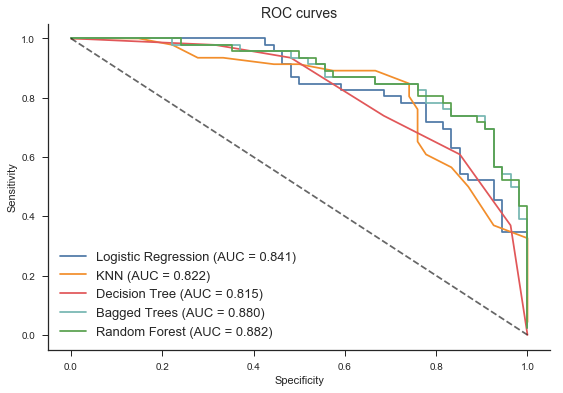

In [28]:
from statlearning import plot_roc_curves

with sns.color_palette(crayon):
    fig, ax = plot_roc_curves(y_test, y_prob, labels=pd.Series(rows))
    plt.show()